In [1]:
import numpy as np
import pandas as pd
import plotly 

import matplotlib.pyplot as plt
import matplotlib as mpl

from terminal_optimization import hydrogen_objects
from terminal_optimization import hydrogen_defaults
from terminal_optimization import hydrogen_system

plotly.tools.set_credentials_file(username='stephh', api_key='aYheUBjQH0kyWL5yo9E6')

# 0. Prepare inputs

In [2]:
startyear = 2019
lifecycle = 20

## 0.1 Generate demand forecast scenario

In [3]:
scenario = 'permanent' #choice between permanent or random

if scenario == 'random': 
    # instantiate a commodity object
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # create a future througput scenario
    lhydrogen.scenario_random(startyear = startyear, lifecycle = lifecycle)
    ammonia.scenario_random(startyear = startyear, lifecycle = lifecycle)
    MCH.scenario_random(startyear = startyear, lifecycle = lifecycle)

    demand = [lhydrogen]

    # plot scenarios 
    if True:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()
else: 
    years = list(range(startyear, startyear+lifecycle))

    demand = []
    for year in years: 
        if year < 2024: 
            demand.append(300_000)
        else: 
            demand.append(1_000_000)

    scenario_data={'year': years, 'volume': demand}

    # instantiate a commodity objects
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

    # Ammonia
    hydrogen_defaults.commodity_ammonia_data['historic_data'] = []
    hydrogen_defaults.commodity_ammonia_data['scenario_data'] = []
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)

    # MCH
    hydrogen_defaults.commodity_MCH_data['historic_data'] = []
    hydrogen_defaults.commodity_MCH_data['scenario_data'] = []
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # combine
    demand = [lhydrogen, ammonia, MCH]

    # plot scenarios 
    if False:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()

## 0.2 Generate vessels

In [4]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instatiate terminal system

In [5]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=True)

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [6]:
Terminal.simulate()


Simulate year: 2019
  Total vessel calls: 0
     Small Hydrogen  calls: 0
     Large Hydrogen calls: 0
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 0.0
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online (@ start of year): inf
     Unloading occupancy planned (@ start of year): inf
     Unloading occupancy online (@ start of year): inf
     waiting time factor (@ start of year): inf
     waiting time occupancy (@ start of year): nan
     throughput online 0
     throughput planned 0
  *** add Berth to elements
     Berth occupancy planned (after adding berth):

c:\users\stephanie lanphen\documents\terminal-optimization\src\terminal_optimization\hydrogen_system.py:1226: RuntimeWarning:

invalid value encountered in double_scalars




     Plant occupancy online (@ start of year): 0.7783312577833126
     a total of 4000 ton of pipeline hinterland service capacity is online; 4000 ton total planned

Simulate year: 2029
  Total vessel calls: 54
     Small Hydrogen  calls: 30
     Large Hydrogen calls: 24
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 1000000.0
     a total of 1 Berth_01 is online; 1 total planned
     a total of 1 Jetty_01 is online; 1 total planned
     a total of 1 jetty_pipeline_01 is online; 1 total planned
     a total of 2 ATank_01 is online; 2 total planned
     a total of 4 H2retrieval_NH3_01 is online; 4 total planned
     a total of 1 hinterland_pipeline_01 is online; 1 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.1202054794520548
     Berth occupancy online (@ start of year): 0.1202054794520548
     Unloading occupancy planned (@ start of year): 0.09246575342

     Revenues: 96360000
     Revenues: 96360000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
     Revenues: 300000000
PV: [-1.49676000e+08 -1.32592956e+08  6.33121077e+07  6.65006473e+07
  6.93082357e+07 -1.57174476e+08 -8.13951254e+07  2.52277134e+08
  2.57978830e+08  2.62999315e+08  2.67419977e+08  2.71312480e+08
  2.74739925e+08  2.77757876e+08  2.80415257e+08  2.82755147e+08
  2.84815478e+08  2.86629651e+08  2.88227075e+08  3.17059111e+08]
NPV: 3282669689.180614


## Report all elements

In [7]:
if True: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)


Liquid hydrogen

{'historic_data':    year   volume
0  2014  1000000
1  2015  1100000
2  2016  1250000
3  2017  1400000
4  2018  1500000, 'scenario_data':     year   volume
0   2019   300000
1   2020   300000
2   2021   300000
3   2022   300000
4   2023   300000
5   2024  1000000
6   2025  1000000
7   2026  1000000
8   2027  1000000
9   2028  1000000
10  2029  1000000
11  2030  1000000
12  2031  1000000
13  2032  1000000
14  2033  1000000
15  2034  1000000
16  2035  1000000
17  2036  1000000
18  2037  1000000
19  2038  1000000, 'type': 'Liquid hydrogen', 'handling_fee': 1000, 'smallhydrogen_perc': 30, 'largehydrogen_perc': 70, 'smallammonia_perc': 0, 'largeammonia_perc': 0, 'handysize_perc': 0, 'panamax_perc': 0, 'vlcc_perc': 0, 'name': 'Liquid hydrogen', 'id': '820d6546-7bae-11e9-ac87-c8ff2870e0c9'}

Ammonia

{'historic_data': [], 'scenario_data': [], 'type': 'Ammonia', 'handling_fee': 300, 'smallhydrogen_perc': 0, 'largehydrogen_perc': 0, 'smallammonia_perc': 40, 'largeammonia_perc'

In [8]:
Terminal.add_cashflow_elements()

(    year        capex  maintenance   insurance        energy     labour  \
 0   2019  149676000.0          0.0         0.0  0.000000e+00        0.0   
 1   2020  150584000.0          0.0         0.0  0.000000e+00        0.0   
 2   2021          0.0    5284600.0   2752600.0  2.510430e+07  1280100.0   
 3   2022          0.0    5284600.0   2752600.0  2.510430e+07  1280100.0   
 4   2023          0.0    5284600.0   2752600.0  2.510430e+07  1280100.0   
 5   2024  442800000.0    5284600.0   2752600.0  2.687542e+07  1280100.0   
 6   2025  345200000.0    5284600.0   2752600.0  2.687542e+07  1280100.0   
 7   2026          0.0   20294600.0  10382600.0  8.365917e+07  1951700.0   
 8   2027          0.0   20294600.0  10382600.0  8.365917e+07  1951700.0   
 9   2028          0.0   20294600.0  10382600.0  8.365917e+07  1951700.0   
 10  2029          0.0   20294600.0  10382600.0  8.365917e+07  1951700.0   
 11  2030          0.0   20294600.0  10382600.0  8.365917e+07  1951700.0   
 12  2031   

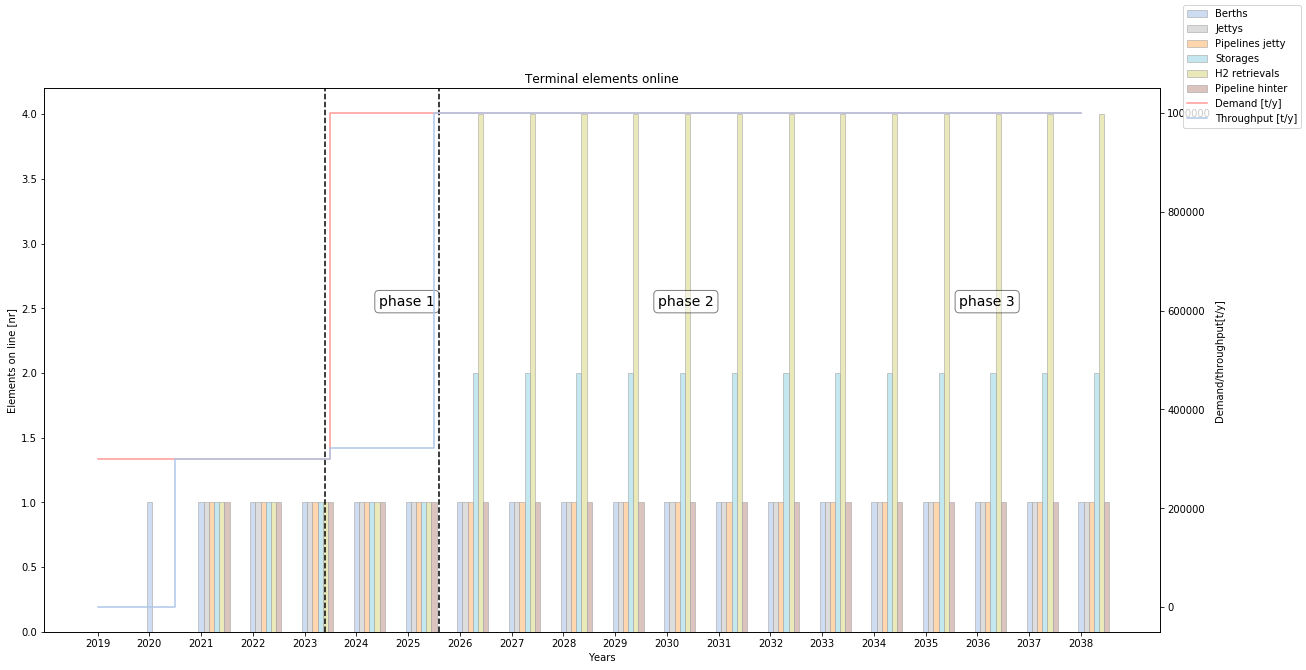

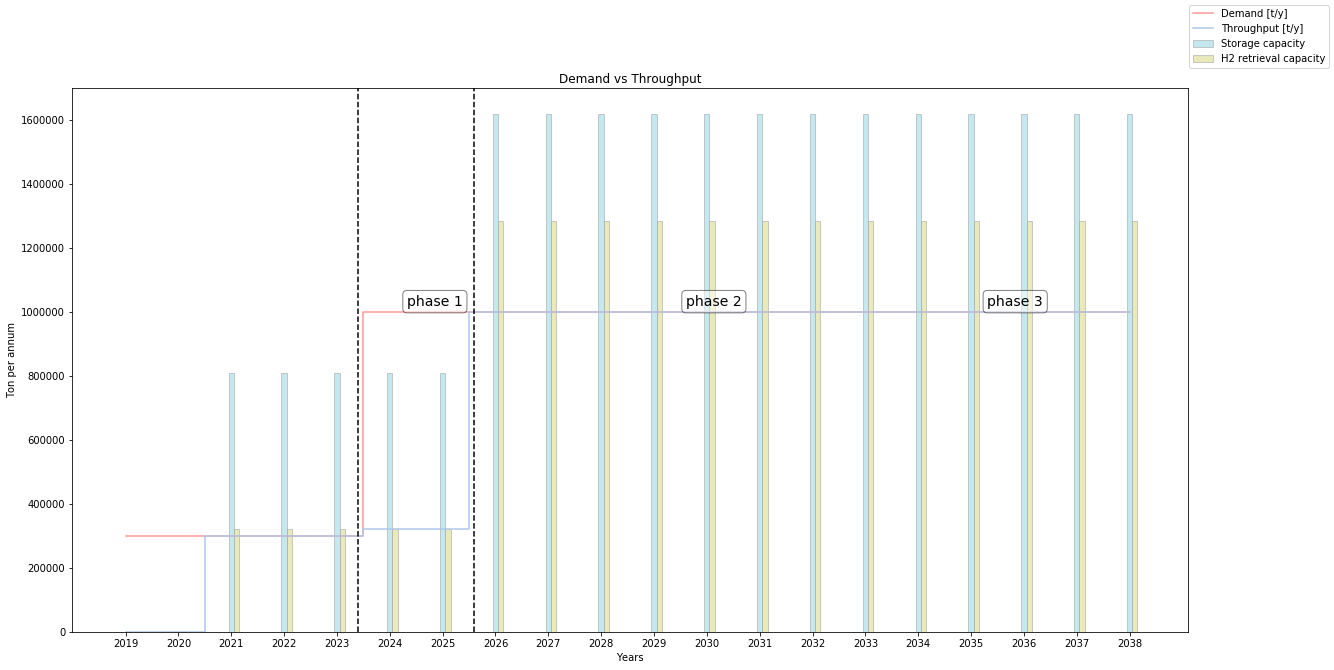

In [9]:
Terminal.terminal_elements_plot()
Terminal.demand_terminal_plot()

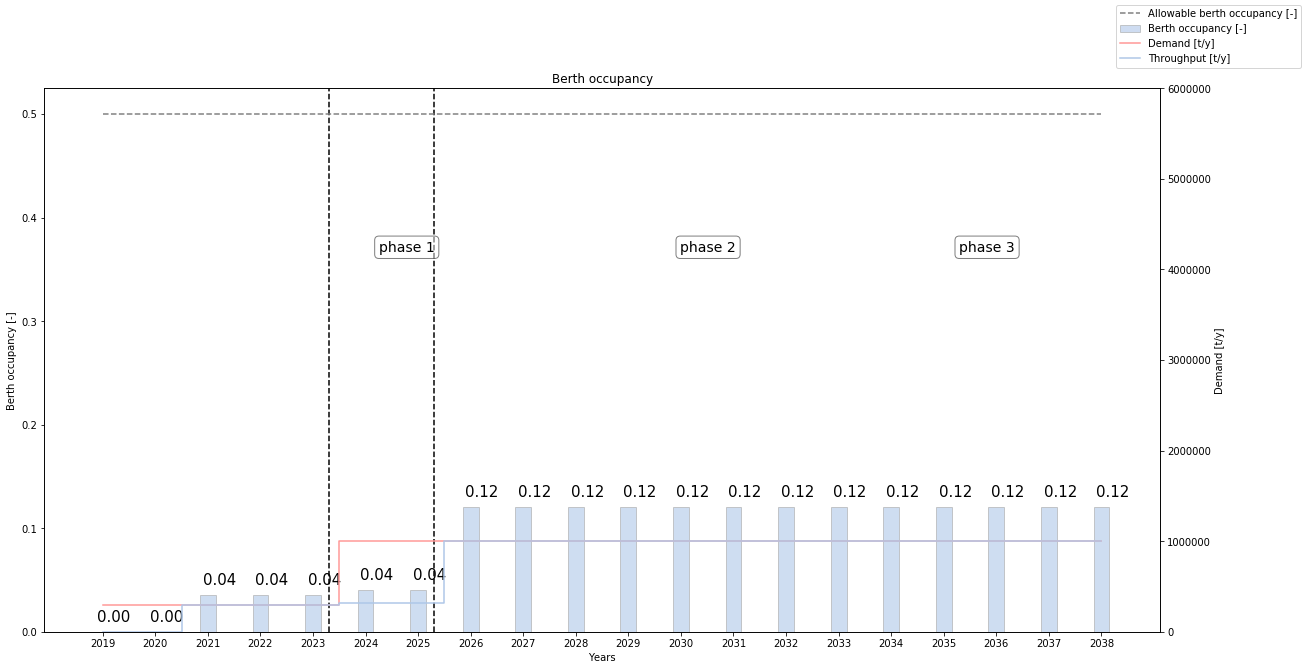

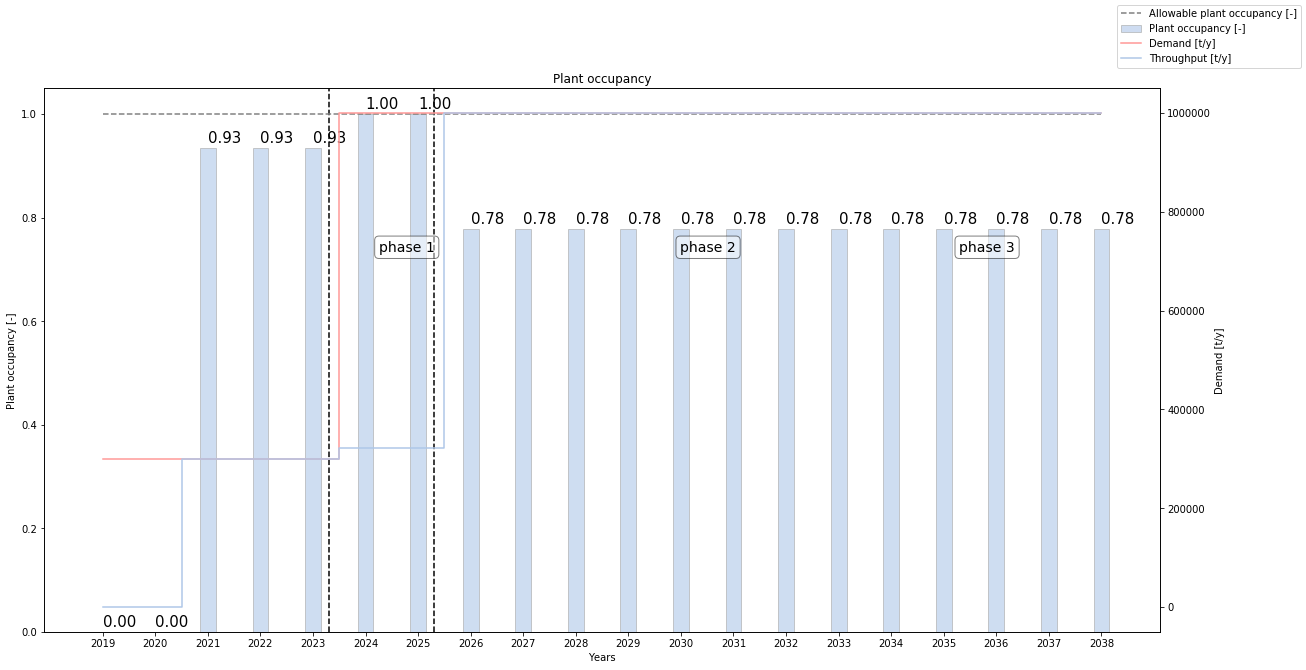

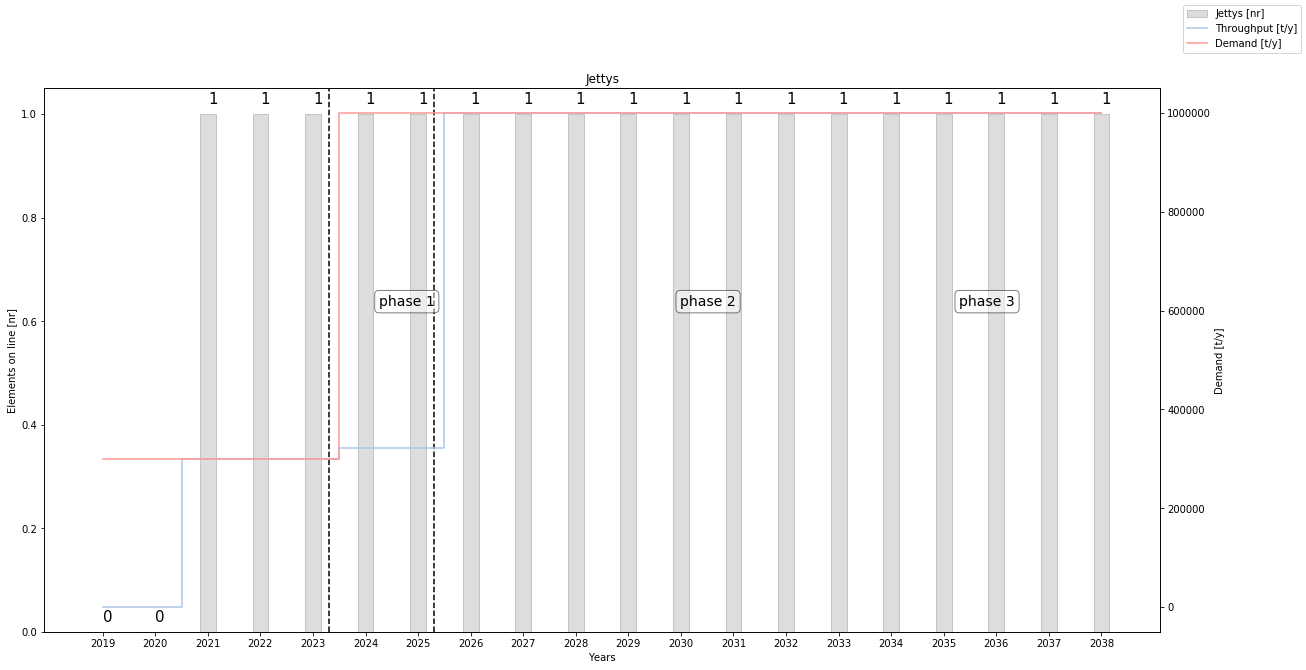

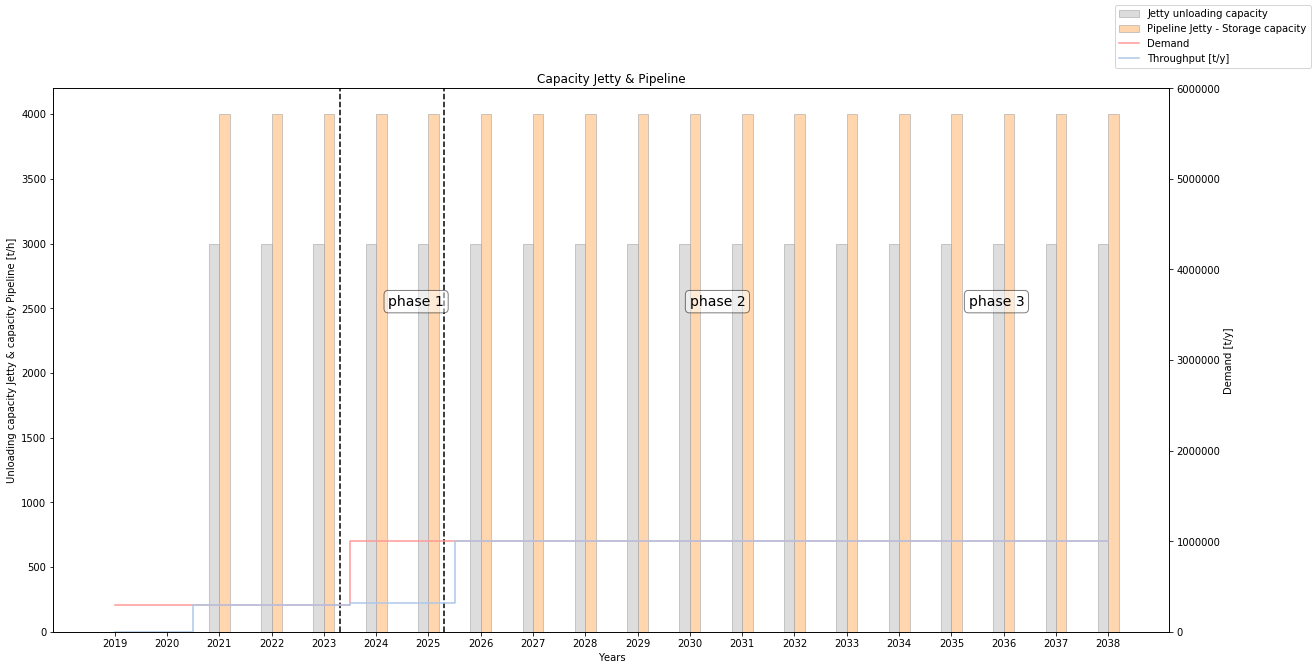

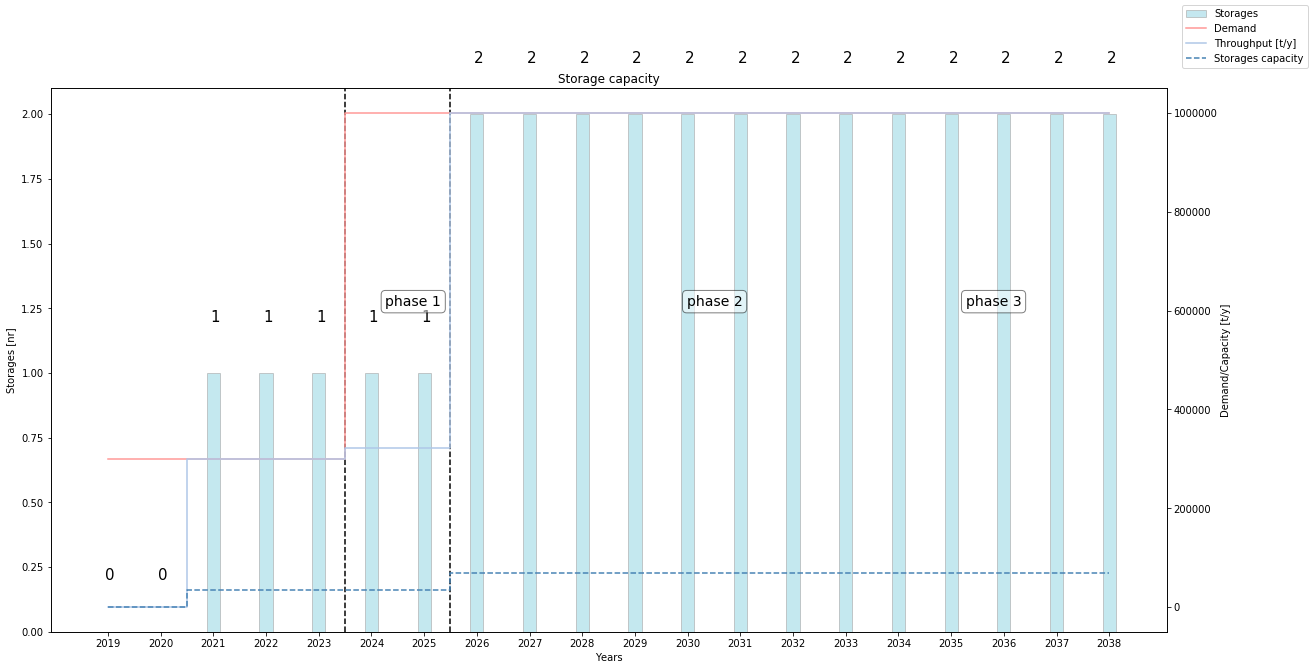

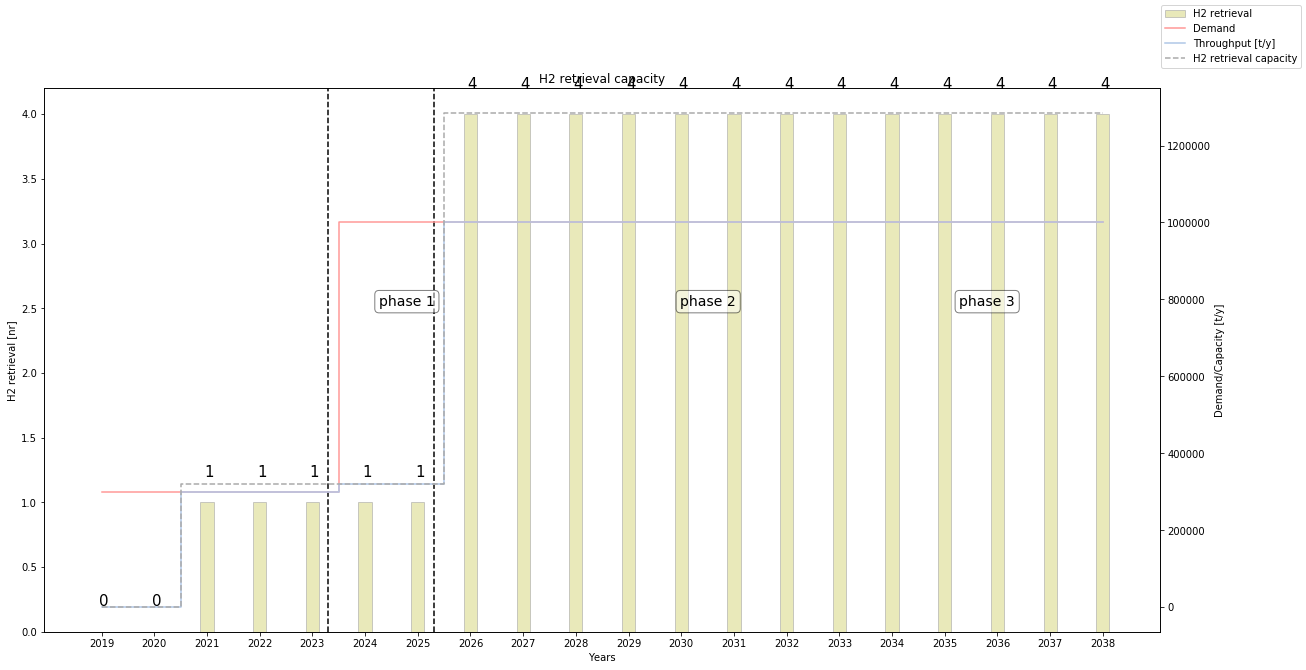

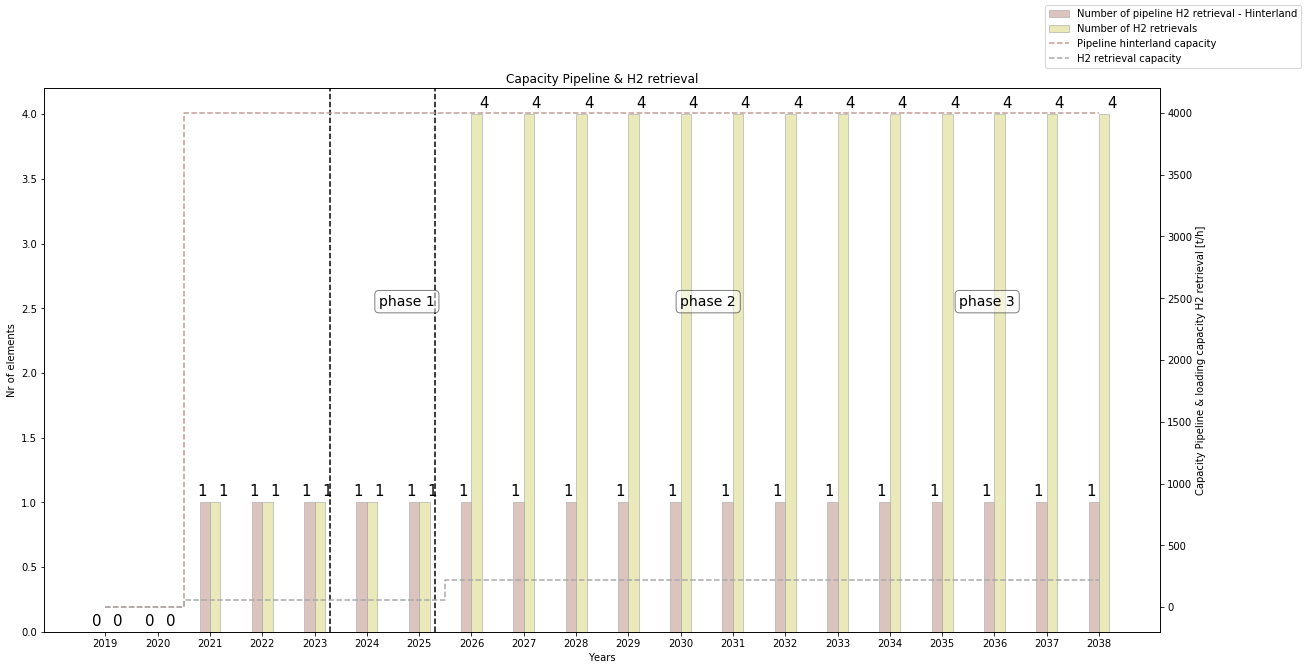

In [10]:
if True: 
    # to plot the terminal occupany's 
    Terminal.terminal_occupancy_plot() #occupancy of the berth 
    Terminal.plant_occupancy_plot() #occupancy of the plant
    
    # to plot the capacities of the different elements 
    Terminal.Jetty_capacity_plot() #jetty
    Terminal.Pipeline1_capacity_plot() #pipeline from jetty to storage
    Terminal.Storage_capacity_plot() #storage
    Terminal.H2retrieval_capacity_plot() # H2 retrieval
    Terminal.Pipeline2_capacity_plot() #pipeline from H2 retrieval to hinterland        

In [11]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

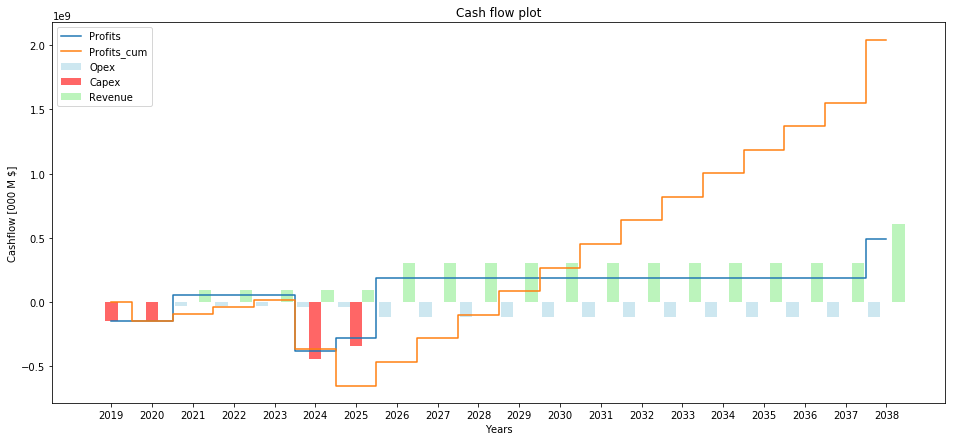

In [12]:
Terminal.cashflow_plot(cash_flows)

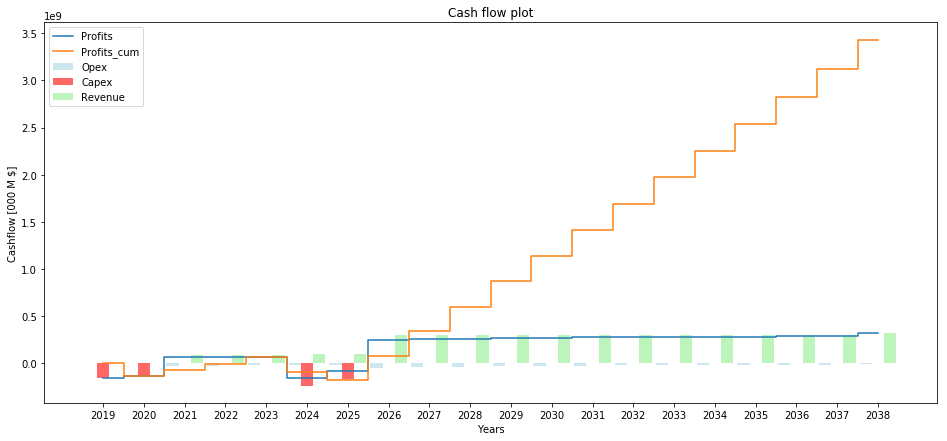

In [13]:
Terminal.cashflow_plot(cash_flows_WACC_real)